<a href="https://colab.research.google.com/github/zibro011/DataScience-Lab9/blob/main/lab9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**INET 4061 Lab 9** <br>
**Adelaide Zibrowski** <br>
**November 9, 2021** <br>
Late with extension granted.

#Overview
In this lab we are given a dataset from https://archive.ics.uci.edu/ml/datasets/wholesale+customers that contains customer spending data in a wholesale grocery store distributor in Portugal. Our task is to put these 440 samples into groups or clusters, so we can get a better understanding of our customers and how they are similar to one another. We do so using two clustering methods: KMeans Clustering and Agglomerative Clustering. Each of these methods is explained in their corresponding section. Finally, we visual the data as clusters to see how each cluster spends their money at the grocery store, so we can use that information to improve our marketing strategies. 

#Data

In [ ]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import stats
import matplotlib.cm as cm

In [ ]:
#upload file
from google.colab import files
uploaded = files.upload()

Saving wholesale-customer-data.csv to wholesale-customer-data (1).csv


In [ ]:
#read file
import io
df = pd.read_csv(io.BytesIO(uploaded['wholesale-customer-data.csv']))

#Exploratory Data Analysis (EDA)

##Understand the Data

In [ ]:
#see first 5 rows
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [ ]:
#see last 5 rows
df.tail()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125
439,1,3,2787,1698,2510,65,477,52


In [ ]:
#see how many rows and columns are in the dataset
df.shape

(440, 8)

In [ ]:
#see how many unique values there are for each variable
df.nunique()

Channel               2
Region                3
Fresh               433
Milk                421
Grocery             430
Frozen              426
Detergents_Paper    417
Delicassen          403
dtype: int64

In [ ]:
#get dataset attributes
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


From the code above, we can see that we have a dataset consisting of 440 rows and 8 columns. The columns are: Channel, Region, Milk, Grocery, Frozen, Detergents_paper, and Delicassen. Channel and Region are categorical variables with 2 values representing horeaca (1) and retail (0) and 3 values representing Lisbon (1), Oporto (2), and Other(3) respectively. The other columns correspond to annual spending on each product type identified in the column name. 

##Clean the Data

In [ ]:
#drop any rows that contain a null value in any column
df= df.dropna(how = 'any', axis = 0)
df.shape

(440, 8)

In [ ]:
#drop any rows that contain an outlier in any column
#here I define an outlier as a value that is more than 3 standard deviations away from the mean
col = df.iloc[:,1:]
df[(np.abs(stats.zscore(col)) < 3)]
df.shape

(440, 8)

In [ ]:
# standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# statistics of scaled data
pd.DataFrame(df_scaled).describe()

,0,1,2,3,4,5,6,7
count,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02
mean,-2.452584e-16,-5.737834e-16,-2.422305e-17,-1.589638e-17,-6.030530e-17,1.135455e-17,-1.917658e-17,-8.276208e-17
std,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00
min,-6.902971e-01,-1.995342e+00,-9.496831e-01,-7.787951e-01,-8.373344e-01,-6.283430e-01,-6.044165e-01,-5.402644e-01
25%,-6.902971e-01,-7.023369e-01,-7.023339e-01,-5.783063e-01,-6.108364e-01,-4.804306e-01,-5.511349e-01,-3.964005e-01
50%,-6.902971e-01,5.906683e-01,-2.767602e-01,-2.942580e-01,-3.366684e-01,-3.188045e-01,-4.336004e-01,-1.985766e-01
75%,1.448652e+00,5.906683e-01,3.905226e-01,1.890921e-01,2.849105e-01,9.946441e-02,2.184822e-01,1.048598e-01
max,1.448652e+00,5.906683e-01,7.927738e+00,9.183650e+00,8.936528e+00,1.191900e+01,7.967672e+00,1.647845e+01


To clean our data, we eliminate any rows that contain null values or outliers. We define an outlier to be a value greater than 3 standard deviations from the mean. Our dataset does not contain any such values, so we do not end up removing any rows. Finally, we scale our data using the StandardScaler function from sklearn. Our data needs to be scaled because KMeans is a distance-based algorithm. That being said, the small magnitudes of the categorical variables compared to the large magnitudes of the other variables will throw off our algorithm. 

#Models

##KMeans Clustering
Our KMeans model, obtained from https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/#h2_14, works by picking k random centroids and assigning each sample to the nearest centroid until all samples have been assigned to a cluster/centroid group. We choose the number of clusters, k, using the elbow method. This method plots the inertia of a KMeans function using different values for k (our graph uses values 1-20). Where the graph creates an "elbow", or where the graph begins to represent a linear equation, corresponds to the number of centroids, or the value of k, that we want to use. This specific implementation of the elbow method is explained in further detail below. 

In [ ]:
# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=2, init='k-means++')

# fitting the k means algorithm on scaled data
kmeans.fit(df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
# inertia on the fitted data
kmeans.inertia_

2599.3873849123083

Inertia is a measure of distance between points in each group. That being said, we want our inertia to be low, but not so low that our clusters are not meaningful. 

Text(0, 0.5, 'Inertia')

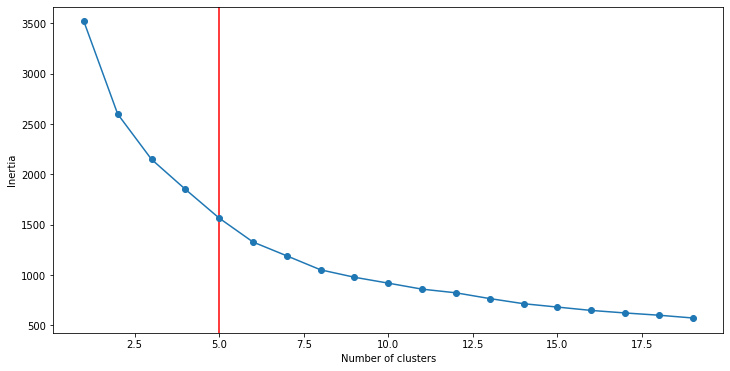

In [ ]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(df_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.axvline(x=5, color = 'r')
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

The plot above illustrates the algorithm's inertia, defined above, as a function of k (number of clusters). I inserted a vertical line at x = 5 to identify the "elbow" of the graph. The elbow could be chosen to be anywhere between x = 5 and x = 8 because that is where the graph starts to resemble a linear equation. This is an important area of the graph because it illustrates where adding another cluster no longer makes a significant improvement to our inertia.

I chose x = 5 as my "elbow" and k value after experimenting with values 5-8 and deciding that 5 clusters made the most meaningful clusters in my opinion. As the number of clusters increases past 5, some clusters begin to have only one point in them which I do not find to be helpful in this situation. 

In [ ]:
# k means using 5 clusters and k-means++ initialization
kmeans = KMeans(n_jobs = -1, n_clusters = 5, init='k-means++', random_state = 123)
kmeans.fit(df_scaled)
pred = kmeans.predict(df_scaled)

In [ ]:
frame = pd.DataFrame(df_scaled)
frame['cluster'] = pred


#create new dataframe to use in boxplots
KMean = df.copy()
KMean['KCluster'] = frame['cluster']

frame['cluster'].value_counts()

0    211
1    125
3     91
2     11
4      2
Name: cluster, dtype: int64

The output of our KMeans model, shown above, tells us that we have 211 samples in Group 1, 125 samples in Group 2, 11 samples in Group 3, 91 samples in Group 4, and 2 samples in Group 5. I set the random state in the KMeans function so the clusters will stay the same regardless of how many times the algorithm is run. 

For n_clusters = 3 The average silhouette_score is : 0.3567685389017652
For n_clusters = 4 The average silhouette_score is : 0.36831361173098737
For n_clusters = 5 The average silhouette_score is : 0.34285654296309154
For n_clusters = 6 The average silhouette_score is : 0.35882504056214026
For n_clusters = 7 The average silhouette_score is : 0.36168536185938693
For n_clusters = 8 The average silhouette_score is : 0.37351193825329115


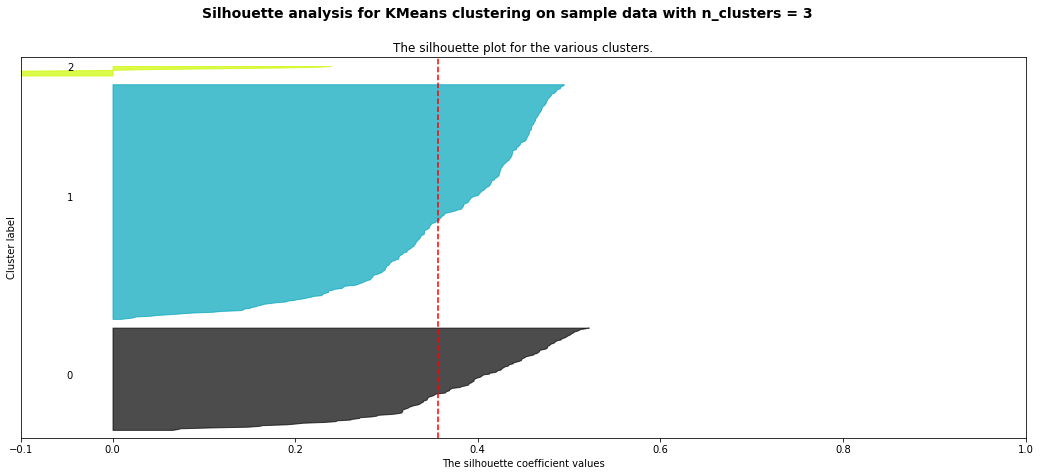

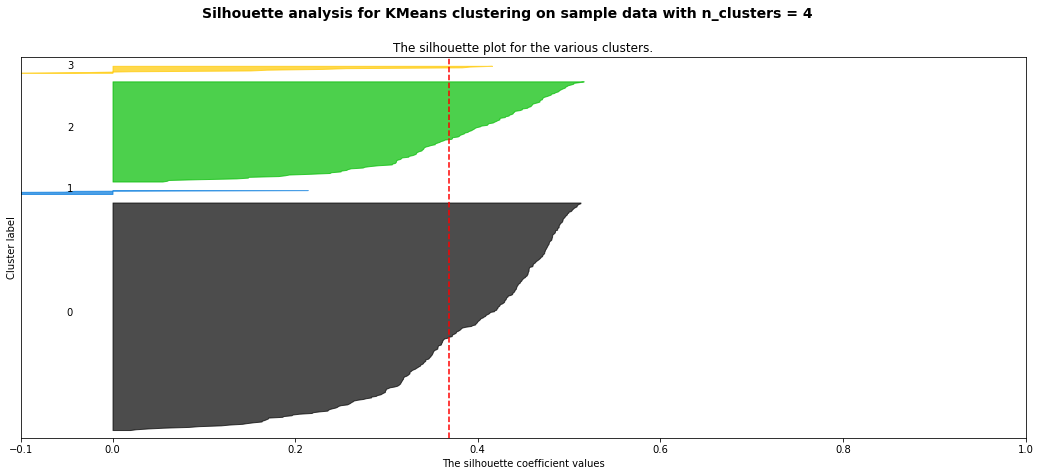

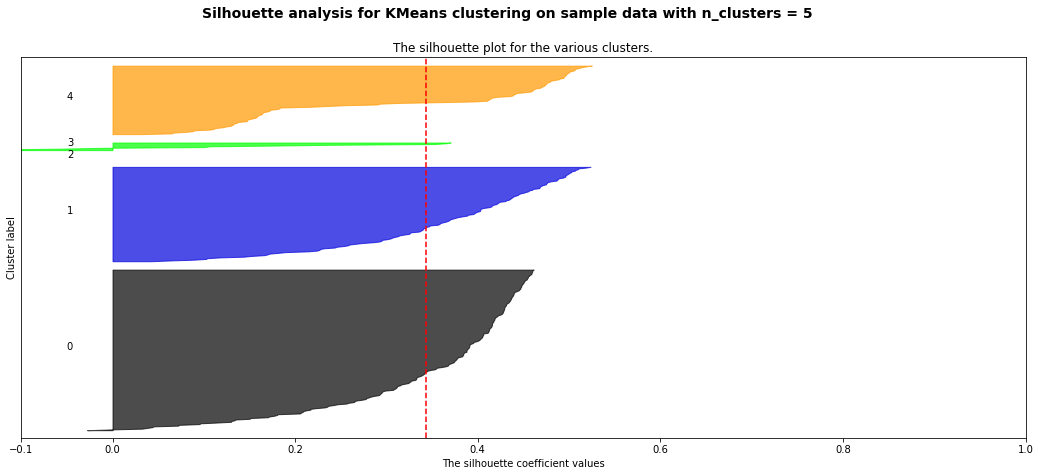

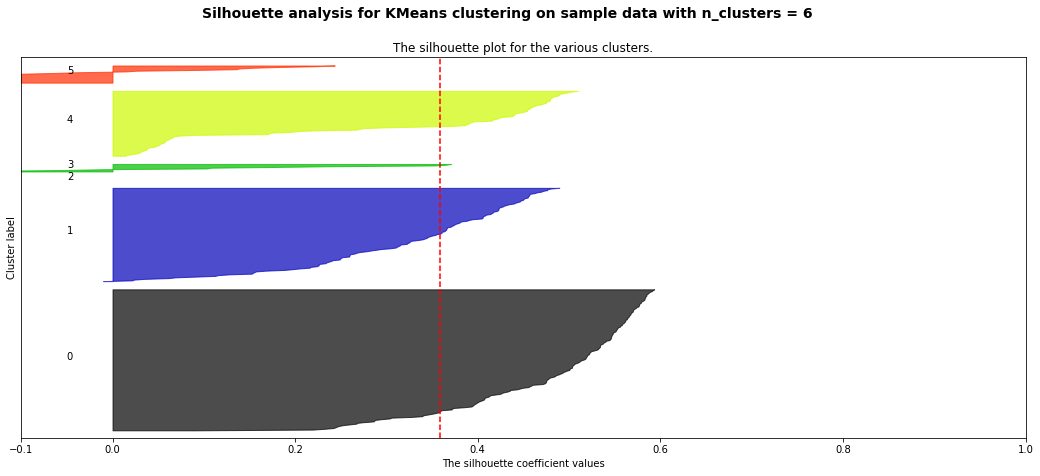

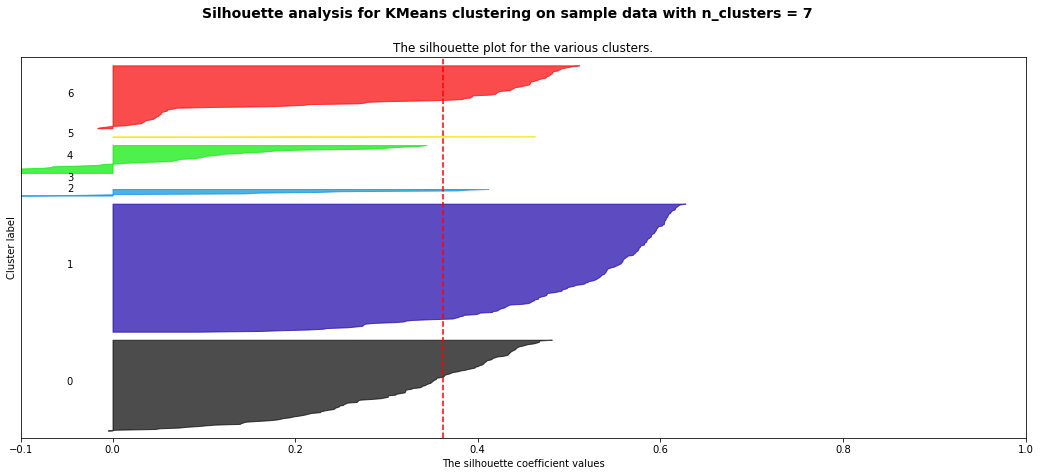

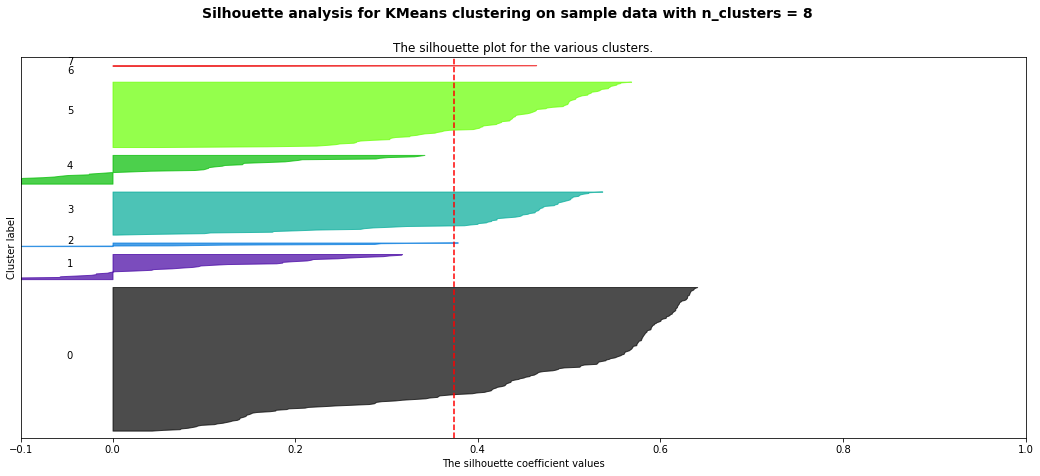

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    # Create a subplot to print one silhouette plot per "line"
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(df_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

The silhouette analysis above was performed using information from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html. Similar to the elbow method, this method performs the KMeans algorithm on the data set using different values of k. Here we used values 3-8. In each of these implementations, the silhouette coefficient of each cluster is calculated. This coefficient is a measure between -1 and 1 of how close the points of different neighboring clusters are to one another. When interpretting these plots, we are looking for plots where the cluster silhouette sizes are roughly uniform, and their coefficients are equal to or above the average silhouette score (represented by the vertical dashed red line in our plots). We can see that all k values besides k = 5 produce at least one cluster with a below average silhouette coefficient. Each of the plots shows a big difference in silhouette sizes, but the plot for k = 5 is arguably the best in this context as well because it only contains one very small cluster while the other plots all contain at least 2 tiny clusters. Ultimately, this analysis leads me to decide that 5 clusters is the ideal number of clusters for this dataset which is the same conclusion that I came to using the elbow method.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


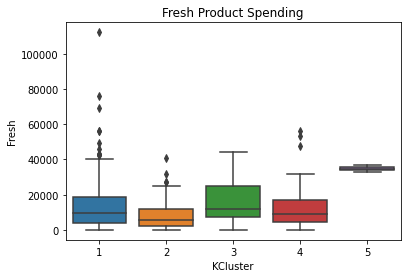

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


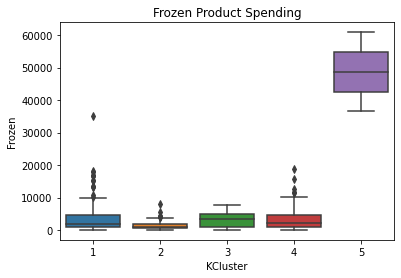

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


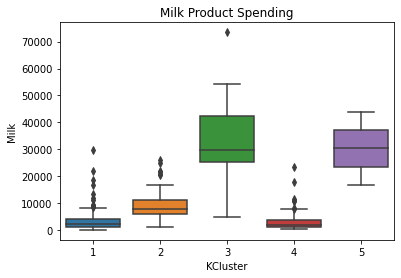

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


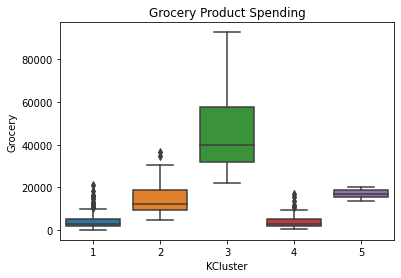

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


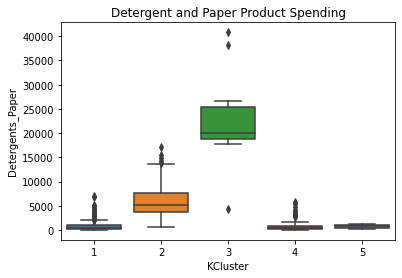

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


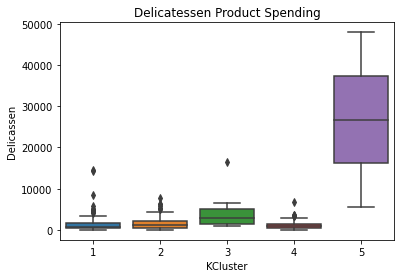

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


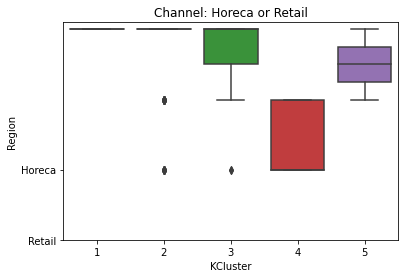

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


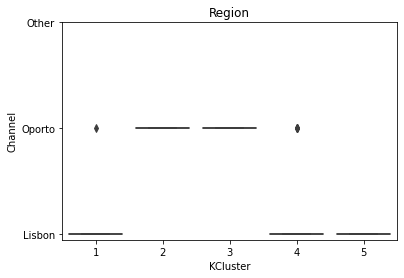

In [ ]:
#output resulting clusters
import seaborn as sns
sns.boxplot(KMean['KCluster'], KMean.Fresh).set(title = 'Fresh Product Spending')
plt.xticks([0,1,2,3,4], [1,2,3,4,5])
plt.show()
sns.boxplot(KMean.KCluster, KMean.Frozen).set(title = 'Frozen Product Spending')
plt.xticks([0,1,2,3,4], [1,2,3,4,5])
plt.show()
sns.boxplot(KMean.KCluster, KMean.Milk).set(title = 'Milk Product Spending')
plt.xticks([0,1,2,3,4], [1,2,3,4,5])
plt.show()
sns.boxplot(KMean.KCluster, KMean.Grocery).set(title = 'Grocery Product Spending')
plt.xticks([0,1,2,3,4], [1,2,3,4,5])
plt.show()
sns.boxplot(KMean.KCluster, KMean.Detergents_Paper).set(title = 'Detergent and Paper Product Spending')
plt.xticks([0,1,2,3,4], [1,2,3,4,5])
plt.show()
sns.boxplot(KMean.KCluster, KMean.Delicassen).set(title = 'Delicatessen Product Spending')
plt.xticks([0,1,2,3,4], [1,2,3,4,5])
plt.show()
sns.boxplot(KMean.KCluster, KMean.Region).set(title = 'Channel: Horeca or Retail')
plt.xticks([0,1,2,3,4], [1,2,3,4,5])
plt.yticks([0,1], ['Retail', 'Horeca'])
plt.show()
sns.boxplot(KMean.KCluster, KMean.Channel).set(title = 'Region')
plt.xticks([0,1,2,3,4], [1,2,3,4,5])
plt.yticks([1,2,3], ['Lisbon', 'Oporto', 'Other'])
plt.show()

Each cluster represents a group of customers who share some similarities in terms of their grocery store spending habits and their location. We can tell how similar each cluster is for each variable's data by analyzing how long the box plot is. For example, Group 5 has a very large boxplot for Delicatessen Product Spending, and Group 3 has extreme outliers for Grocery Product Spending and Milk Product Spending. Alternatively, Group 5 has extremely small boxplots for Detergent and Paper Product Spending and Grocery Product Spending. 

These differences in boxplots tell us how we should use our data and its corresponding clusters. When the boxplot is very big, it would not be logical to make predictions using that data. For example, we do not want to make assumptions on Group 3's Milk Product Spending because the data is so spread out we cannot make a useful prediction from it. On the other hand, we can confidently make predictions about Group 5's Grocery Product Spending because the data is so close together. That does not mean we can make definitive predictions with Group 5 in terms of Grocery Product Spending, but it does mean that it could provide us with predictions that are useful in our marketing strategies. Therefore, we would use this data to identify the clusters with small boxplots and make predictions about groups of customers in those areas. 

##Agglomerative Clustering
Agglomerative clustering is a specific type of hierarchical clustering that identifies two clusters that are closest to one another and merges them together until all the clusters are merged together. This method works from the bottom-up, meaning it begins with each sample being its own cluster and works until all the clusters have joined into one. This merging can be illustrated in a dendrogram. This section was performed using information from https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/.

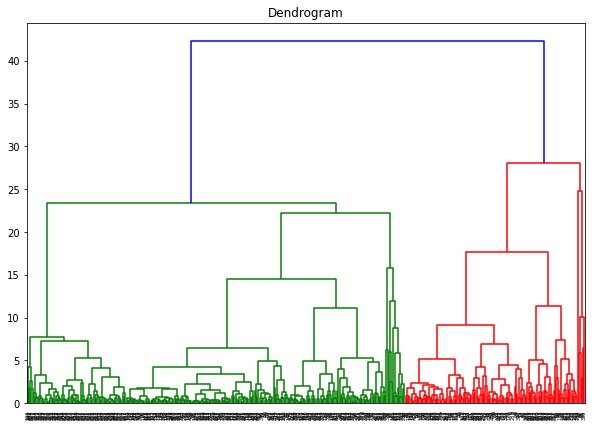

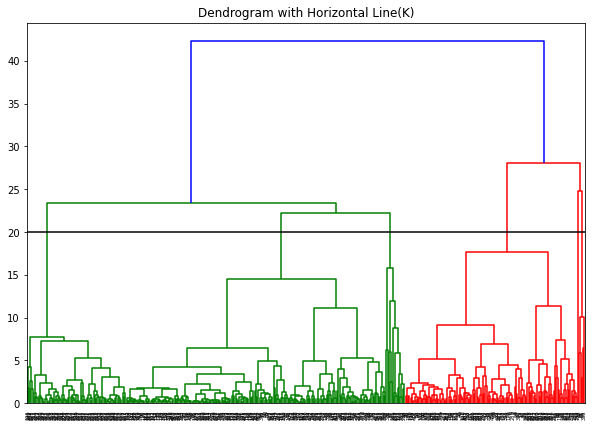

In [ ]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram")  
dend = shc.dendrogram(shc.linkage(df_scaled, method='ward'))
plt.show()
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram with Horizontal Line(K)")  
dend = shc.dendrogram(shc.linkage(df_scaled, method='ward'))
plt.axhline(y=20, color = 'black')
plt.show()

In the dendograms above, I first illustrated the dendrogram using general hierarchical clustering via the scipy dendrogram function. Then, I looked at that dendrogram and identified where I saw the groups becoming what I consider to be reasonably sized in terms of these data samples. I wanted to include as many clusters as I could, but I was not sure if I wanted to include the very small cluster in red on the far right. I decided to include it because without it I would only have 3 clusters, and I had one very small cluster in my KMeans model as well. 

Therefore, I inserted a horizontal line at y = 20. This line intercepts 6 vertical lines which means I should use 6 clusters. However, a dendrogram is not a perfect tool in determining number of clusters, and it is up to interpretation. That being said, I previously went ahead with my analysis using 6 clusters, but one of those clusters only had one sample. Having a cluster with one sample is not useful to me, so I decided to go down one cluster to 5 clusters as I had in my KMeans implementation. I still had a cluster with only one sample, so I decided to return to 6 clusters to see how it works out in comparison to my KMeans implementation.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
cluster.fit_predict(df_scaled)
b = cluster.fit_predict(df_scaled)

frame2 = pd.DataFrame(df_scaled)
frame2['cluster'] = b

#create new dataframe to use in boxplots
Agg = df.copy()
Agg['HCluster'] = b

frame2['cluster'].value_counts()


5    205
0    136
4     78
2     15
1      5
3      1
Name: cluster, dtype: int64

From the output above, we can see that Group 1 has 136 samples, Group 2 has 5 samples, Group 3 has 15 samples, Group 4 has 1 sample, Group 5 has 78 samples, and Group 6 has 205 samples. Unlike KMeans Clustering, these numbers will not change regardless of how many times the algorithm is run.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


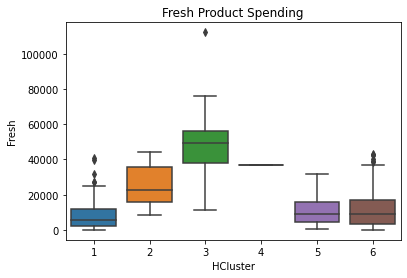

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


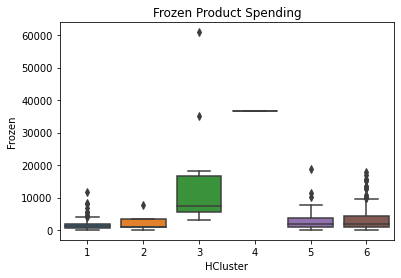

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


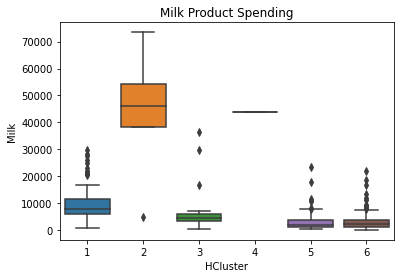

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


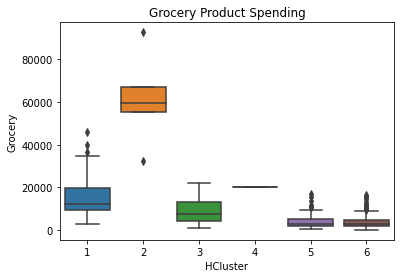

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


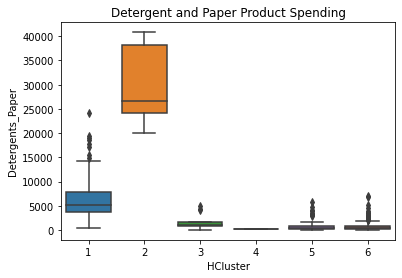

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


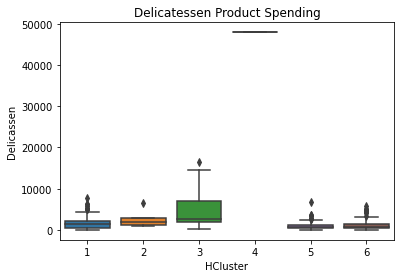

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


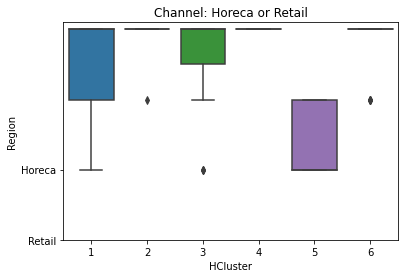

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


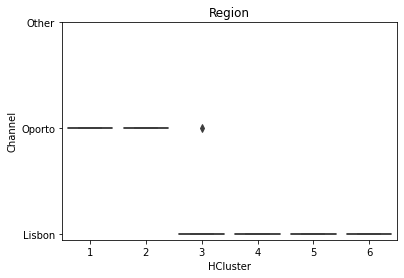

In [ ]:
#output resulting clusters
sns.boxplot(Agg.HCluster, Agg.Fresh).set(title = 'Fresh Product Spending')
plt.xticks([0,1,2,3,4,5], [1,2,3,4,5,6])
plt.show()
sns.boxplot(Agg.HCluster, Agg.Frozen).set(title = 'Frozen Product Spending')
plt.xticks([0,1,2,3,4,5], [1,2,3,4,5,6])
plt.show()
sns.boxplot(Agg.HCluster, Agg.Milk).set(title = 'Milk Product Spending')
plt.xticks([0,1,2,3,4,5], [1,2,3,4,5,6])
plt.show()
sns.boxplot(Agg.HCluster, Agg.Grocery).set(title = 'Grocery Product Spending')
plt.xticks([0,1,2,3,4,5], [1,2,3,4,5,6])
plt.show()
sns.boxplot(Agg.HCluster, Agg.Detergents_Paper).set(title = 'Detergent and Paper Product Spending')
plt.xticks([0,1,2,3,4,5], [1,2,3,4,5,6])
plt.show()
sns.boxplot(Agg.HCluster, Agg.Delicassen).set(title = 'Delicatessen Product Spending')
plt.xticks([0,1,2,3,4,5], [1,2,3,4,5,6])
plt.show()
sns.boxplot(Agg.HCluster, Agg.Region).set(title = 'Channel: Horeca or Retail')
plt.xticks([0,1,2,3,4,5], [1,2,3,4,5,6])
plt.yticks([0,1], ['Retail', 'Horeca'])
plt.show()
sns.boxplot(Agg.HCluster, Agg.Channel).set(title = 'Region')
plt.xticks([0,1,2,3,4,5], [1,2,3,4,5,6])
plt.yticks([1,2,3], ['Lisbon', 'Oporto', 'Other'])
plt.show()

After determining that my k should be 6, I split the samples into their corresponding clusters using the agglomerative clustering equation from sklearn. I then plotted each cluster as a boxplot function of each variable in the dataset. 

Similarly to my KMeans analysis, I can evaluate the similarity of each group or cluster by analyzing the size of its box plot. In these clusters, our highest variances are Groups 1 and 2 for Detergent and Paper Product Spending, Grocery Product Spending, and Milk Product Spending. Since these two Groups had such high variance in 3 separate variables, it could be true that these clusters are not actually that similar and therefore not that useful. In contrast, Group 4 has the least variance in every variable, but that is to be expected and provides no use to us because there is only one sample in the group. Some clusters that were very similar in these examples include Group 2's Delicatessen Product Spending and Frozen Product Spending. 

As I mentioned in the KMeans analysis, it would be smart to use the clusters and variables with the smallest boxplots(least variance) to make predictions about our customers for marketing purposes. For example, we may find it useful to make predictions regarding Group 2's Frozen Product Spending.

#Conclusions
Given a dataset containing wholesale grocery store customer spending habits, we utilized KMeans Clustering and a type of Hierarchical Clustering called Agglomerative Clustering. Both of these clustering methods iteratively add samples to neighboring clusters using different algorithms. The purpose of creating these clusters is to make predictions about certain groups of customers for marketing purposes. 

After analyzing the clustering method outputs using boxplots, it is clear that KMeans Clustering was more successful in this instance. We can identify this success by the low variance in box plots as compared to the Agglomerative Clustering's boxplots' high variance. However, both clustering methods identified a number of clusters that was close to the other's which is interesting.

Taking this information into consideration, it would be logical to split our data into 5 or 6 clusters using KMeans Clustering. Then, we can analyze the the boxplots for each cluster and variable to decide what groups and variables we can make predictions on to improve our marketing strategies.